<a href="https://colab.research.google.com/github/Larbi96-enet/Cure-EMG-signal-classification/blob/main/PROCESSEDDATA_(another_features_combination)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters

mpl.rcParams['figure.figsize'] = (8,1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Processed_data = pd.read_csv('/content/drive/MyDrive/data/ProcessedEMG.csv',header = None)
Processed_data.columns = ["channel0","channel1","channel2","channel3","channel4","channel5","channel6","channel7"]
Processed_data = Processed_data.drop([0], axis=0)
dflist=[]
dflist.append(Processed_data)
data0= pd.read_csv('/content/drive/MyDrive/data/EMG-data.csv')
classes = data0['class']
labels=data0['label']
dflist.append(classes)
dflist.append(labels)
df=pd.concat(dflist,axis=1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.dtypes

channel0     object
channel1     object
channel2     object
channel3     object
channel4     object
channel5     object
channel6     object
channel7     object
class       float64
label       float64
dtype: object

In [ ]:
df["channel0"]=df.astype(float)
df["channel1"]=df.astype(float)
df["channel2"]=df.astype(float)
df["channel3"]=df.astype(float)
df["channel4"]=df.astype(float)
df["channel5"]=df.astype(float)
df["channel6"]=df.astype(float)
df["channel7"]=df.astype(float)

In [ ]:
df.dtypes

channel0    float64
channel1    float64
channel2    float64
channel3    float64
channel4    float64
channel5    float64
channel6    float64
channel7    float64
class       float64
label       float64
dtype: object

In [ ]:
df.drop([0])


,channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7,class,label
1,1.462582e-06,1.462582e-06,1.462582e-06,1.462582e-06,1.462582e-06,1.462582e-06,1.462582e-06,1.462582e-06,0.0,1.0
2,3.448808e-06,3.448808e-06,3.448808e-06,3.448808e-06,3.448808e-06,3.448808e-06,3.448808e-06,3.448808e-06,0.0,1.0
3,1.426897e-05,1.426897e-05,1.426897e-05,1.426897e-05,1.426897e-05,1.426897e-05,1.426897e-05,1.426897e-05,0.0,1.0
4,1.260082e-05,1.260082e-05,1.260082e-05,1.260082e-05,1.260082e-05,1.260082e-05,1.260082e-05,1.260082e-05,0.0,1.0
5,1.018470e-05,1.018470e-05,1.018470e-05,1.018470e-05,1.018470e-05,1.018470e-05,1.018470e-05,1.018470e-05,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
4237903,8.297107e-07,8.297107e-07,8.297107e-07,8.297107e-07,8.297107e-07,8.297107e-07,8.297107e-07,8.297107e-07,0.0,36.0
4237904,2.085376e-06,2.085376e-06,2.085376e-06,2.085376e-06,2.085376e-06,2.085376e-06,2.085376e-06,2.085376e-06,0.0,36.0
4237905,7.471378e-07,7.471378e-07,7.471378e-07,7.471378e-07,7.471378e-07,7.471378e-07,7.471378e-07,7.471378e-07,0.0,36.0
4237906,1.431597e-06,1.431597e-06,1.431597e-06,1.431597e-06,1.431597e-06,1.431597e-06,1.431597e-06,1.431597e-06,0.0,36.0


In [ ]:
subjects_data=df.groupby(['label','class'])
print(type(subjects_data))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


In [ ]:
import numpy as np

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)


def SD(data):
    return np.std(data)

def RMS (data):
  ms = 0
  for i in data:  
    ms = ms + i*i
    ms = ms / len(data)
    RMS = np.sqrt(ms)
    return RMS 

def MAV (data):
    sum = 0
    for i in data:
        sum += np.absolute(i)
    MAV = sum/len(data)
    return MAV

'''def WL (data):
    sum = 0
    for i in range(len(data)-1):
        sum += np.absolute(data[i+1]-data[i])
    WL = np.log(sum)
    return WL '''
def IEMG (data):
     IEMG = np.trapz(data)
     return IEMG

In [ ]:
from time import time
start=time()
features=subjects_data.agg([ 'min','max',np.ptp,rms,RMS,abs_diffs_signal,MAV,IEMG])

end=time()
print('feature calculation time of one subject one class')
print((end-start)/(36*7))

feature calculation time of one subject one class
0.16689475377400717


In [ ]:
features=features.reset_index()
features.head()


label class      channel0  ...         channel7                    
                        min  ... abs_diffs_signal       MAV      IEMG
0   1.0   0.0  1.873120e-10  ...              NaN       NaN       NaN
1   1.0   1.0  8.374821e-10  ...         0.014032  0.000007  0.047628
2   1.0   2.0  6.486447e-09  ...         0.215433  0.000089  0.607589
3   1.0   3.0  1.085570e-08  ...         0.184099  0.000080  0.589099
4   1.0   4.0  2.015412e-09  ...         0.045062  0.000020  0.137404

[5 rows x 66 columns]

In [ ]:
features=features.dropna()
features.shape

(253, 66)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,recall_score,roc_auc_score, precision_score,f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,StratifiedKFold

In [ ]:
classifiers = [#manhattan,4,distance
    KNeighborsClassifier(metric='manhattan',weights='distance',n_neighbors=4),
    SVC(C=3, gamma=0.04), #2,0.01
    DecisionTreeClassifier(criterion= 'entropy',max_depth= 7,max_features= 'auto',random_state= 20),
    RandomForestClassifier(bootstrap=False,max_depth=8,max_features='sqrt',min_samples_leaf=1,
                          min_samples_split=2,n_estimators=100),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    LogisticRegression(C=0.05, penalty='l2')]

In [ ]:
import warnings
warnings.filterwarnings('always') 
clf_performace={'accuracy':[],'f1score':[],'training_time':[],'testing_time':[]}
for clfs in classifiers:
    #pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    accuracy=[]
    f1score=[]
    recall=[]
    precision=[]
    training_time=[]
    testing_time=[]
    for i in range(1,37):
        train=features[features['label']!=i]
        test=features[features['label']==i]
        X_train=train.iloc[:,2::].values
        X_test=test.iloc[:,2::].values
        y_train=train['class']
        y_test=test['class']
        training_start=time()
        clf = make_pipeline(StandardScaler(), clfs)
        clf.fit(X_train, y_train)
        training_end=time()
        testing_start=time()
        y_pred=clf.predict(X_test)
        testing_end=time()
        acc=accuracy_score(y_test,y_pred)
        recall.append(recall_score(y_test,y_pred,average='macro'))
        #precision.append(precision_score(y_test,y_pred,average='macro'))
        f1score.append(f1_score(y_test,y_pred,average='macro'))
        accuracy.append(acc)
        training_time.append(training_end-training_start)
        testing_time.append(testing_end-testing_start)
        #print('subject {} accuracy is {}'.format(i,acc))
    print(name,np.mean(accuracy))
    clf_performace['accuracy'].append(accuracy)
    clf_performace['f1score'].append(f1score)
    clf_performace['training_time'].append(np.mean(training_time))
    clf_performace['testing_time'].append(np.mean(testing_time))

KNeighborsClassifier 0.49437830687830686
SVC 0.5023148148148148


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier 0.4859457671957672


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier 0.4624669312169313


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier 0.48296957671957674


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and 

GaussianNB 0.5054563492063492


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LinearDiscriminantAnalysis 0.462797619047619


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression 0.5178571428571429


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
df=pd.DataFrame(np.stack((a,f)),columns=['KNN','SVM','DT','RF','GB','NB','LDA','LR'],
            index=['Accuracy','F1-score'])
df

,KNN,SVM,DT,RF,GB,NB,LDA,LR
Accuracy,0.486938,0.494378,0.470734,0.498181,0.482970,0.500827,0.478175,0.517857
F1-score,0.440454,0.437831,0.426135,0.443981,0.436111,0.424184,0.402756,0.445122


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


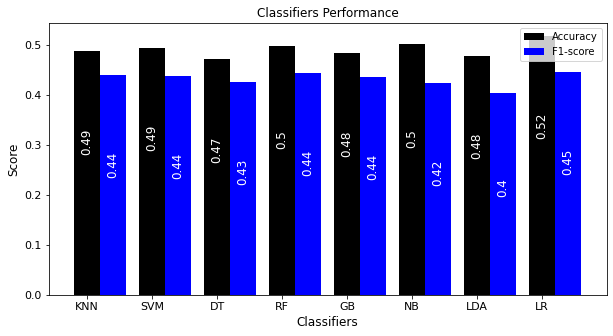

In [ ]:
classifier=df.loc['F1-score'].index
y_pos = np.arange(len(classifier))
w=0.4

plt.figure(figsize=(10,5))
plt.bar(y_pos,df.loc['Accuracy'].values,align='center',width=w,label='Accuracy',color='black')
plt.bar(y_pos+w,df.loc['F1-score'].values,align='center',width=w,label='F1-score',color='blue')

ya=df.loc['Accuracy'].values
for index, value in enumerate(ya):
    plt.text(index-0.1,value-0.2, str(np.round(value,2)),rotation=90,color='white',fontsize=12)

yf=df.loc['F1-score'].values
for index, value in enumerate(yf):
    plt.text(index+w-0.1,value-0.2, str(np.round(value,2)),rotation=90,color='white',fontsize=12)


plt.xticks(y_pos, classifier,fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Score',fontsize=12)
plt.xlabel('Classifiers',fontsize=12)
plt.title('Classifiers Performance',fontsize=12)
plt.legend()
plt.savefig('result.eps',dip=300)

In [ ]:
pd.DataFrame(zip(np.array(clf_performace['training_time'])*65,np.array(clf_performace['testing_time'])),
            columns=['training_time','testing_time'],
            index=['KNN','SVM','DT','RF','GB','NB','LDA','LR'])

,training_time,testing_time
KNN,0.150587,0.001561
SVM,0.711512,0.000550
DT,0.410531,0.000267
RF,13.882049,0.008617
GB,179.828235,0.001120
NB,0.132135,0.000490
LDA,0.504833,0.000367
LR,3.754622,0.000320
